# **KSP 5.0 Selection Assignment**





In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.spatial import distance
from scipy.stats import linregress
from scipy.optimize import curve_fit

# Section 1: Calculating the Redshift of Galaxies

You are given the data for all the galaxies in the cluster in the file 'galaxy.csv'.

This includes the name of the galaxy, observed wavelength of the $H\alpha$ line $\lambda_{H\alpha}$, Right Ascension at J2000.0 and Declination and J2000.0 (You can read more about RA and Dec [here](https://en.wikipedia.org/wiki/Equatorial_coordinate_system))

In [32]:
galaxy_data = pd.read_csv('data/galaxy.csv')
rest_wavelength = 6562.8    # H-alpha rest wavelength in Angstroms
c = 299792458 # speed of light in m/s
galaxy_data['Redshift'] = (galaxy_data['Observed Wavelength of H-alpha']/rest_wavelength) - 1 # Redshift
galaxy_data['Radial Velocity'] = c * galaxy_data['Redshift'] # Radial Velocity in m/s
galaxy_data.to_csv('data/galaxy.csv', index=False) # Save the updated data to the file
# for index, row in galaxy_data.iterrows():
#     print(row)


Since the galaxies would have some radial velocities with respect to us, the wavelengths we observed would be [redshifted](https://en.wikipedia.org/wiki/Redshift) due to doppler effect.

Using the value of the Observed Wavelength of $H\alpha$ line (Rest Wavelength $\lambda_{H\alpha0} = 6562.8nm)$, calculate the redshift of the galaxies in our cluster.

Use this to find their radial velocities of the galaxies and plot it.

(Assume that the observed wavelength has been correscted for the motion of earth around sun, and motion of sun around the center of Milky Way. Put more simply, these are the wavelengths you would have observed if you were at rest at the center of Milky Way)

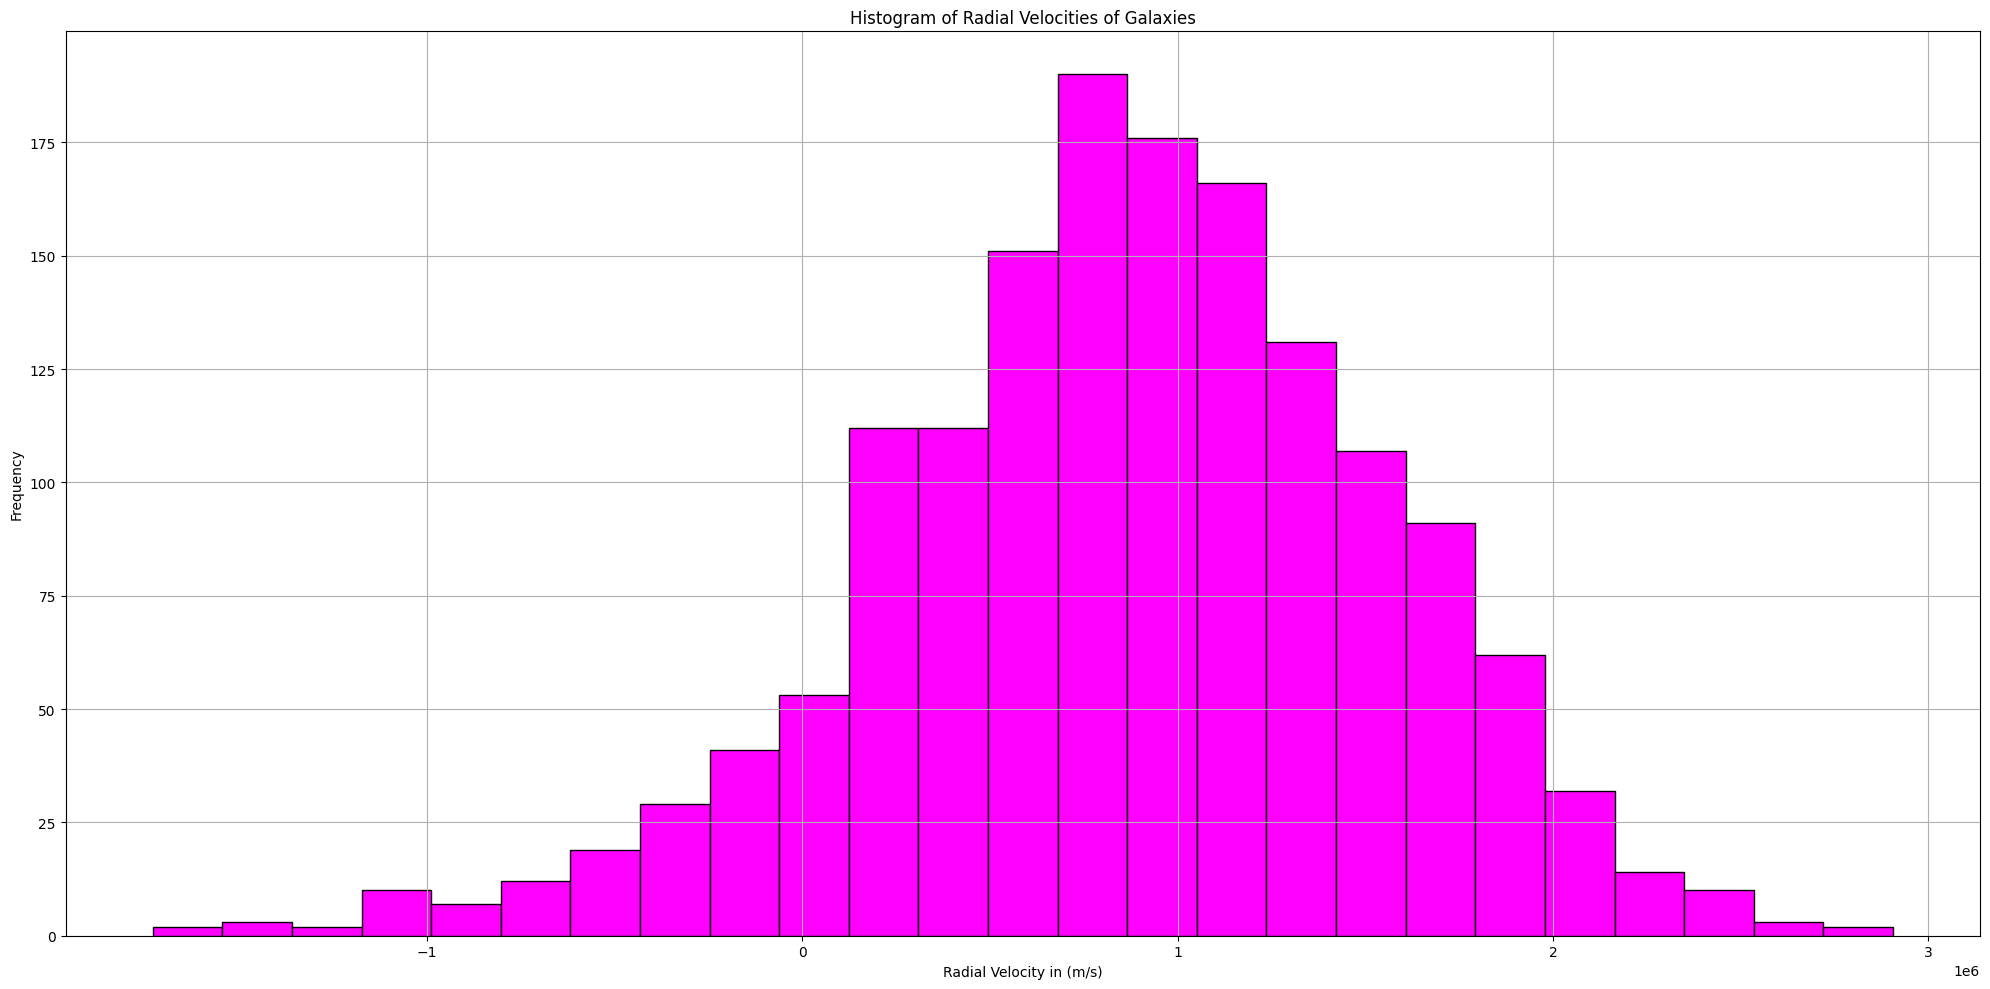

In [33]:
plt.figure(figsize=(20, 10))
plt.hist(galaxy_data['Radial Velocity'], bins=25, color='magenta', edgecolor='black')
plt.title('Histogram of Radial Velocities of Galaxies')
plt.xlabel('Radial Velocity in (m/s)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

Using the data from galaxy.csv, answer the following questions.

For your convenience, the RA and Dec data has been converted from the format $a^\circ b^m c^s$ to $xx^\circ$ below


In [34]:
temp = galaxy_data['RA J2000.0'].str.split(' ', expand=True)
galaxy_data['RA J2000.0'] = temp[0].astype(float) + temp[1].astype(float) / 60 + temp[2].astype(float) / 3600
temp = galaxy_data['Dec J2000.0'].str.split(' ', expand=True)
galaxy_data['Dec J2000.0'] = temp[0].astype(float) + temp[1].astype(float) / 60 + temp[2].astype(float) / 3600

***

###Q1.1. What is the approximate angular size of the galaxy cluster?

Approximate Angular Size of the Cluster: 18.6477176680254 deg

***

###Q1.2. Can you comment anything about the rotation of the galaxies around the center of the cluster.
HINT: You may find it useful to plot a scatter plot of RA and DEC with radial velocity as colormap.

Galaxies closer to the celestial equator are moving towards the center of the cluster. This movement could be due to gravitational interactions within the cluster. Galaxies closer to the center experience stronger gravitational forces, causing them to move towards it. On the other hand, Galaxies away from the celestial equator are moving further away. The gravitational interactions within the cluster can lead to peculiar velocities, causing galaxies to move in different directions relative to the cluster's center.



***

Cluster Center: 12.484632021253521 deg, 10.295171510156871 deg
Approximate Angular Size of the Cluster: 18.6477176680254 deg


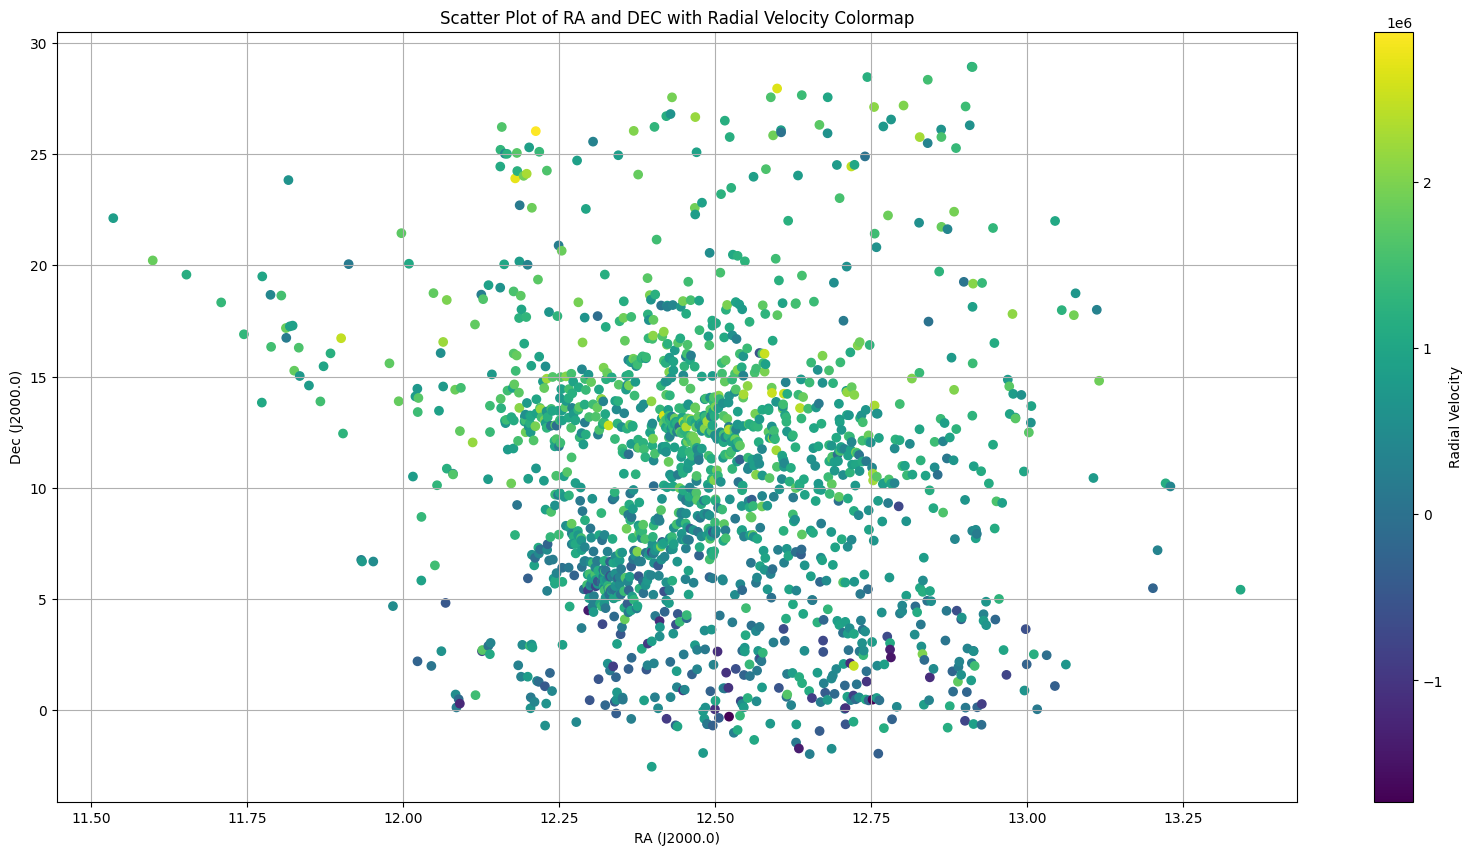

In [35]:
coords = SkyCoord(galaxy_data['RA J2000.0'], galaxy_data['Dec J2000.0'], unit='deg')
mean_ra = coords.ra.mean()
mean_dec = coords.dec.mean()
cluster_center = SkyCoord(mean_ra, mean_dec, frame='icrs')
print(f"Cluster Center: {cluster_center.ra}, {cluster_center.dec}")
cluster_size = coords.separation(cluster_center).max()
print(f"Approximate Angular Size of the Cluster: {cluster_size.to(u.deg)}")

plt.figure(figsize=(20, 10))
sc = plt.scatter(galaxy_data['RA J2000.0'], galaxy_data['Dec J2000.0'], c=galaxy_data['Radial Velocity'], cmap='viridis')
plt.colorbar(sc, label='Radial Velocity')
plt.xlabel('RA (J2000.0)')
plt.ylabel('Dec (J2000.0)')
plt.title('Scatter Plot of RA and DEC with Radial Velocity Colormap')
plt.grid(True)
plt.show()

#Section 2: Calibrating Cepheids Data

NOTE: Although there are no prerequisities for this section, it relies a bit on knowledge about cepheids and their Period-Luminosity Relation. Necessary resource links have been provided wherever needed. You are strongly encouraged to use the internet to aid as a reference whenever needed.
***

The [Gaia Mission](https://en.wikipedia.org/wiki/Gaia_(spacecraft) aims at cataloging and create a precise three-dimensional map of astronomical objects throughout the Mily Way. It maps the motion of the stars, which encode the origin and subsequent evolution of the Milky Way. The spectrophotometric measurements provide detailed physical properties of all stars observed, characterizing their luminosity, effective temperature, gravity and elemental composition.





In [36]:
gaia_data = pd.read_csv('data/gaia.csv')
gaia_data['Distance in parsecs'] = (1 / gaia_data['parallax']) * 1000
gaia_data['Absolute Magnitude'] = gaia_data['mean apparent magnitude'] - 5 * np.log10(gaia_data['Distance in parsecs']) + 5
gaia_data.to_csv('data/gaia.csv', index=False) # Save the updated data to the file
# for index, row in gaia_data.iterrows():
#     print(row)

Cepheids are a particular type of variable stars that pulsates radially, varying in both diameter and temperature. They **changes in brightness**, with a **well-defined stable period and amplitude**.

The file 'gaia.csv' includes data for about 5000 Cepheid Variable Stars in our own galaxy. In particular, the file contains the following data fields:
   
*   Unique ID of the Source Star
*   Parallax (in milli arcseconds) : You can read more about parallax [here](https://en.wikipedia.org/wiki/Stellar_parallax)
*   Mean **Apparent** Magnitude ($m$)
*   TIme period of Pulsations P(in days)



Classical Cepheids follow the [Period Luminosity Law](https://en.wikipedia.org/wiki/Period-luminosity_relation#The_relations), also commonly known as the Leavitt Law.

It basically states that there is an empirical relation between the pulsation period $(P)$ of a Cepheid Star and it's **Absolute Magnitude** ($M$) of the form -

#### $\begin{equation}M = \alpha \log_{10}(P \text{(in days)}) + \beta \end{equation}$
***

### Your aim is to verify Leavitt Law for cepheids using the given data, and find the values of $\alpha$ and $\beta$.

You may find it helpful to use the function 'poly_fit' in numpy for this.

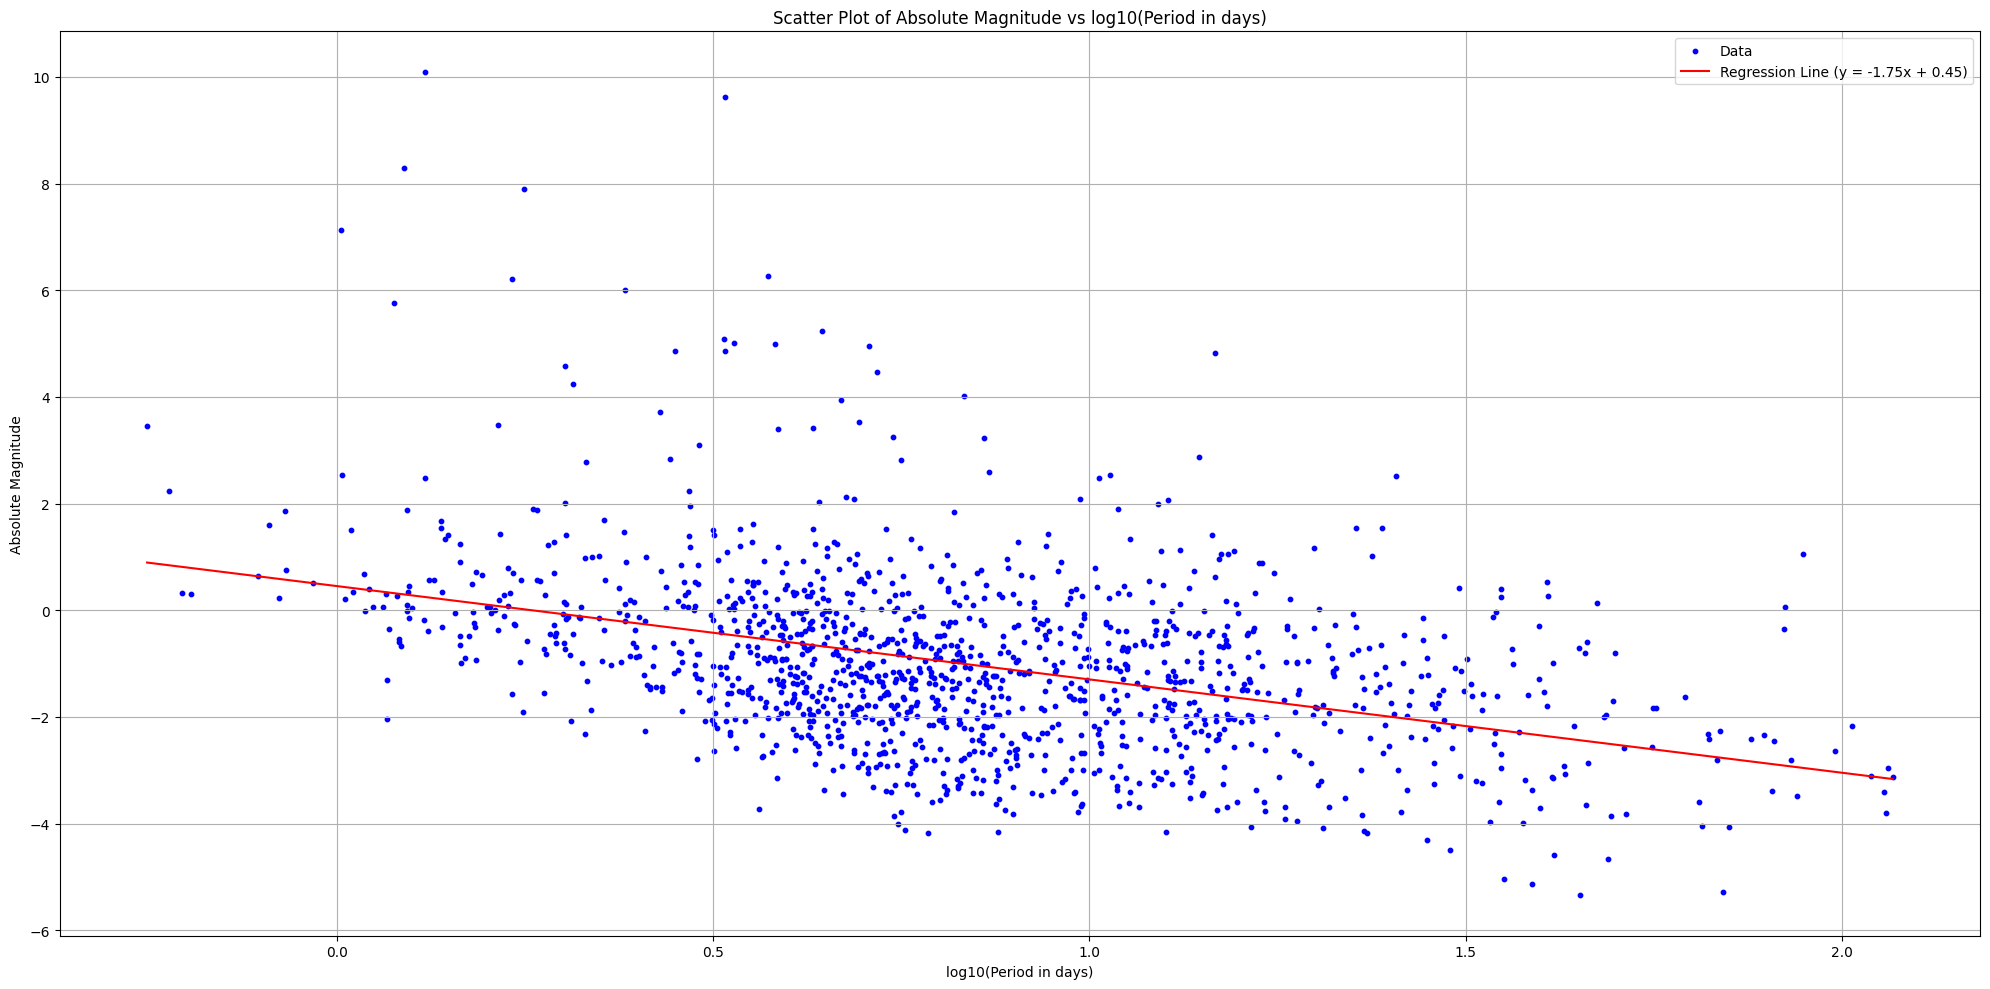

alpha (Slope): -1.750162556886607
beta (Intercept): 0.45296165103033975


In [37]:
# Get the scatter plot of M and log_10(P) and the best fit line
plt.figure(figsize=(20, 10))
plt.scatter(np.log10(gaia_data['time period']), gaia_data['Absolute Magnitude'], color='blue', label='Data', s=10)  # Adjusted point size
plt.xlabel('log10(Period in days)')
plt.ylabel('Absolute Magnitude')
plt.title('Scatter Plot of Absolute Magnitude vs log10(Period in days)')
plt.grid(True)

# Perform linear regression using polyfit
x = np.log10(gaia_data['time period'])
y = gaia_data['Absolute Magnitude']
coefficients = np.polyfit(x, y, 1)  # Fit a first-degree polynomial (linear)
a, b = coefficients

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
y_values = a * x_values + b
plt.plot(x_values, y_values, color='red', label=f'Regression Line (y = {a:.2f}x + {b:.2f})')

plt.legend()
plt.tight_layout()
plt.show()

print(f"alpha (Slope): {a}")
print(f"beta (Intercept): {b}")

***
### Some useful information about the Magnitude system

The brightness of a star as seen by some observer is dependent on the observer's distance from the star as well as the intrinsic brightness of the star (ignoring any absorption in the intervening space).

In astronomy, brightness of a star, as seen by some observer, is measured in terms of its **apparent magnitude ($m$)**. For two stars (1 and 2) with fluxes $f_1$ and $f_2$ respectively, their apparent magnitudes $m_1$ and $m_2$ are related by:

$m_1 - m_2 = 2.5 \log_{10} \left( \frac{f_1}{f_2} \right)$

**Absolute magnitude ($M$)** of any star is its apparent magnitude if the star was exactly 10 parsecs away from the observer. Thus, $M$ only depends on the intrinsic brightness of the star.

***


# Section 3: Getting the distances to our galaxies

Now that we have our period-luminosity relation, we can observe cepheids in the galaxies in our cluster and use this to get the distances to our galaxies. (Yes, this is possible! Hubble Telescope actually observed Cepheids in the galaxies in Virgo Cluster)


For this, you have been given the data file 'cepheid.csv' which contains the following data fields:
*   Unique ID of the Cepheid
*   Name of the Galaxy to which it belongs
*   Mean Apparent Magnitude (m)
*   Time Period of Pulsation (in days)

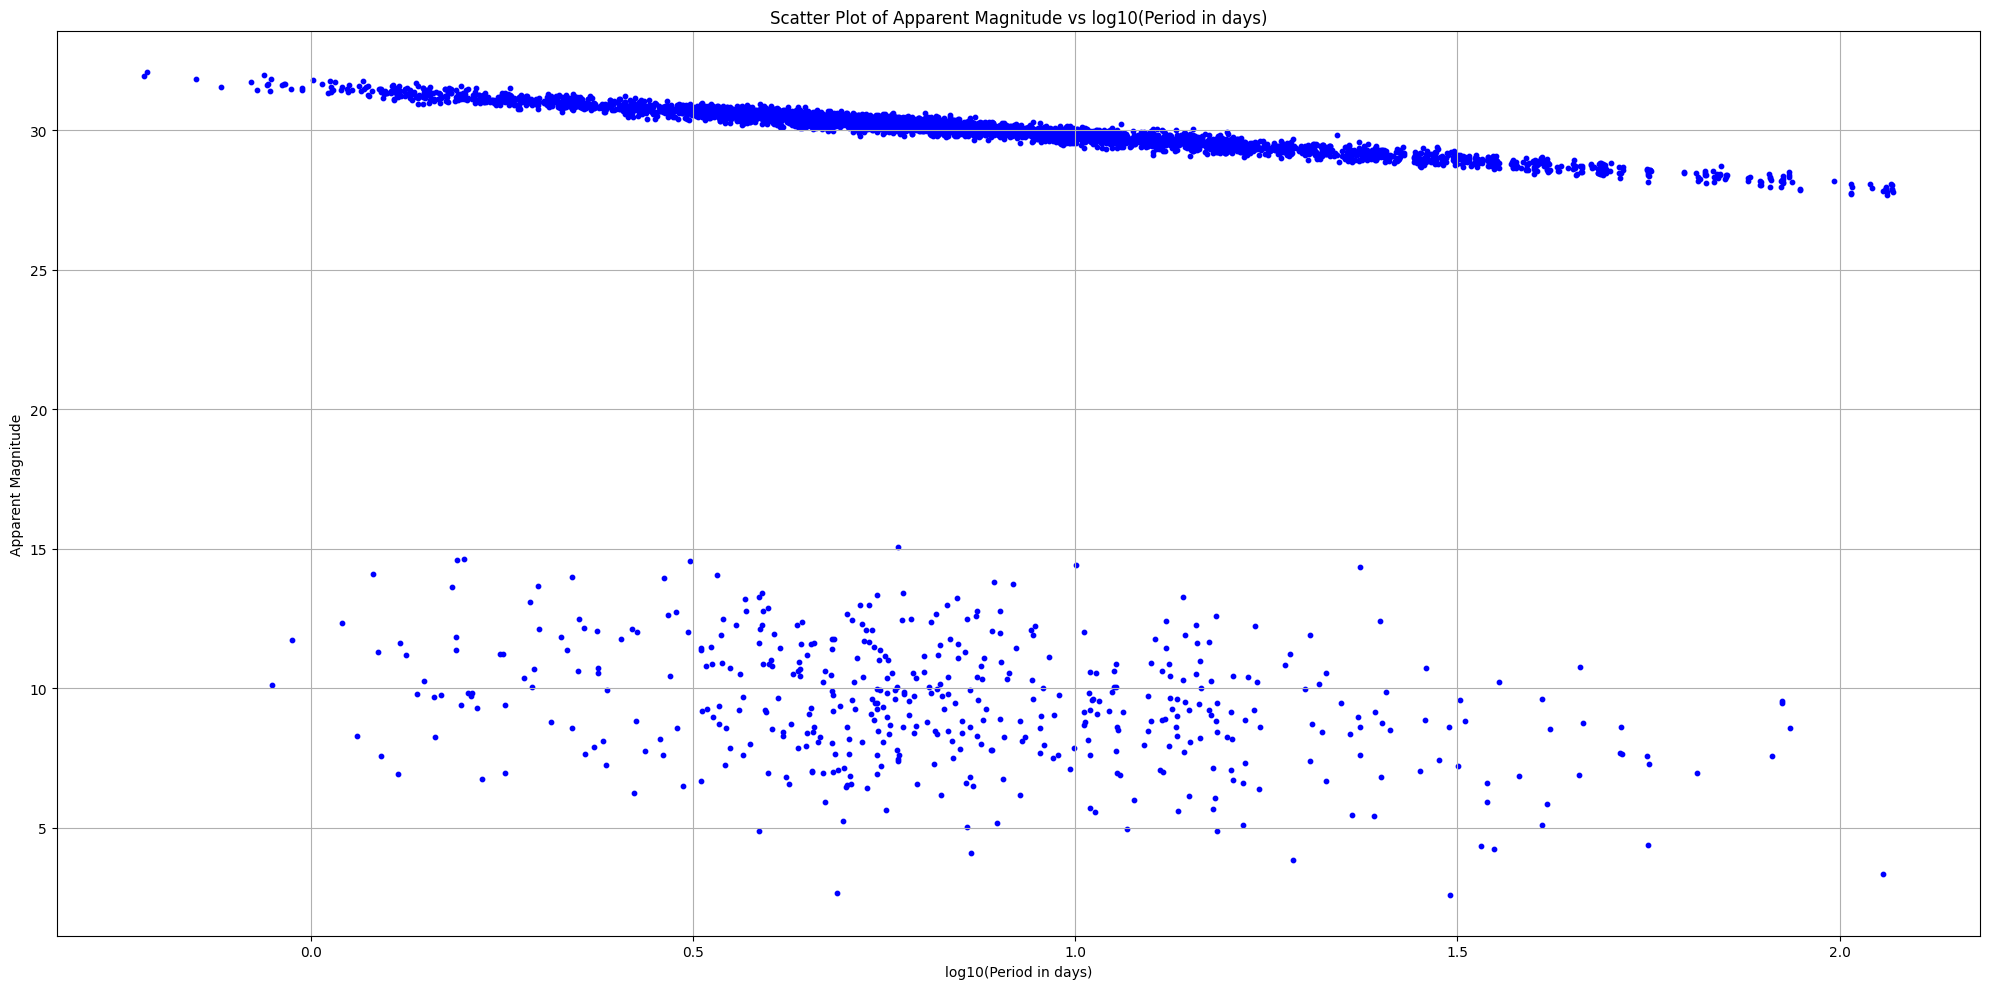

In [38]:
cepheid_data = pd.read_csv('data/cepheid.csv')

# Plot Apparent Magnitude vs log10(Period) for the Cepheids
plt.figure(figsize=(20, 10))
plt.scatter(np.log10(cepheid_data['Period']), cepheid_data['Apparent Magnitude'], color='blue', label='Data', s=10)  # Adjusted point size
plt.xlabel('log10(Period in days)')
plt.ylabel('Apparent Magnitude')
plt.title('Scatter Plot of Apparent Magnitude vs log10(Period in days)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Use the graph obtained to filter data using a threshold value

In [39]:
cepheid_data = pd.read_csv('data/cepheid.csv')
good_data = cepheid_data['Apparent Magnitude'] > 25
cepheid_data = cepheid_data[good_data] 

# Calculate the Absolute Magnitude and Distance to each Cepheid
cepheid_data['Absolute Magnitude'] = a * np.log10(cepheid_data['Period']) + b
cepheid_data['Distance in parsecs'] = 10 ** ((cepheid_data['Apparent Magnitude'] - cepheid_data['Absolute Magnitude']) / 5 + 1)
cepheid_data.to_csv('data/cepheid.csv', index=False) # Save the updated data to the file
# for index, row in cepheid_data.iterrows():
#     print(row)

# # Now find an estimate for the distance to each galaxy in the cluster
# galaxy_data = pd.read_csv('data/galaxy.csv')
# galaxy_data['Distance in parsecs'] = 0
# cepheid_data.sort_values(by='Galaxy_ID')
# for index, row in galaxy_data.iterrows():
#     # print(row)
#     distances = []
#     for index2, row2 in cepheid_data.iterrows():
#         if row2['Galaxy_ID'] == row['Name']:
#             # print(f"{row2['Galaxy_ID']} - {row2['Distance in parsecs']}")
#             distances.append(row2['Distance in parsecs'])
#     if len(distances) > 0:
#         # print(np.average(distances))
#         galaxy_data.loc[index, 'Distance in parsecs'] = np.mean(distances)
#         # print(row['Distance in parsecs'])

# # print(galaxy_data['Distance in parsecs'])
# galaxy_data.to_csv('data/galaxy.csv', index=False) # Save the updated data to the file
# # print(galaxy_data)
# # for index, row in galaxy_data.iterrows():
# #     print(row)

# Group Cepheid data by galaxy
cepheid_grouped = cepheid_data.groupby('Galaxy_ID')

# Calculate mean distance for each galaxy
mean_distances = cepheid_grouped['Distance in parsecs'].mean()

# Assign mean distances to galaxies
galaxy_data['Distance in parsecs'] = galaxy_data['Name'].map(mean_distances)

galaxy_data.to_csv('data/galaxy.csv', index=False)

Use the Period-Luminosity Law derived in Section-2 and the above data to find an estimate for the distance to each galaxy in the cluster.

Make sure to handle outliers in the above data. The data may contain some cepheids that actually DO NOT belong to the given galaxy, but it just seems to us that this is the case since they fall along the same line of sight.
***



# Section 4: Getting the Hubble's Constant

The famous [Hubble's Law](https://en.wikipedia.org/wiki/Hubble%27s_law) is the observation that galaxies are moving away from Earth at speeds proportional to their distance.

$v = H_0 d$

where $H_0$ is the proportionality constant, also known as the Hubble's Constant.

Now that we have an estimate for the radial velocities and distance to the galaxies in our cluster, we need to find an estimate of the Hubble Constant (H).

Fit gaussians on your velocity and distance data and report the mean and standard deviation of the same. Also plot the histograms and the fitted gaussian.

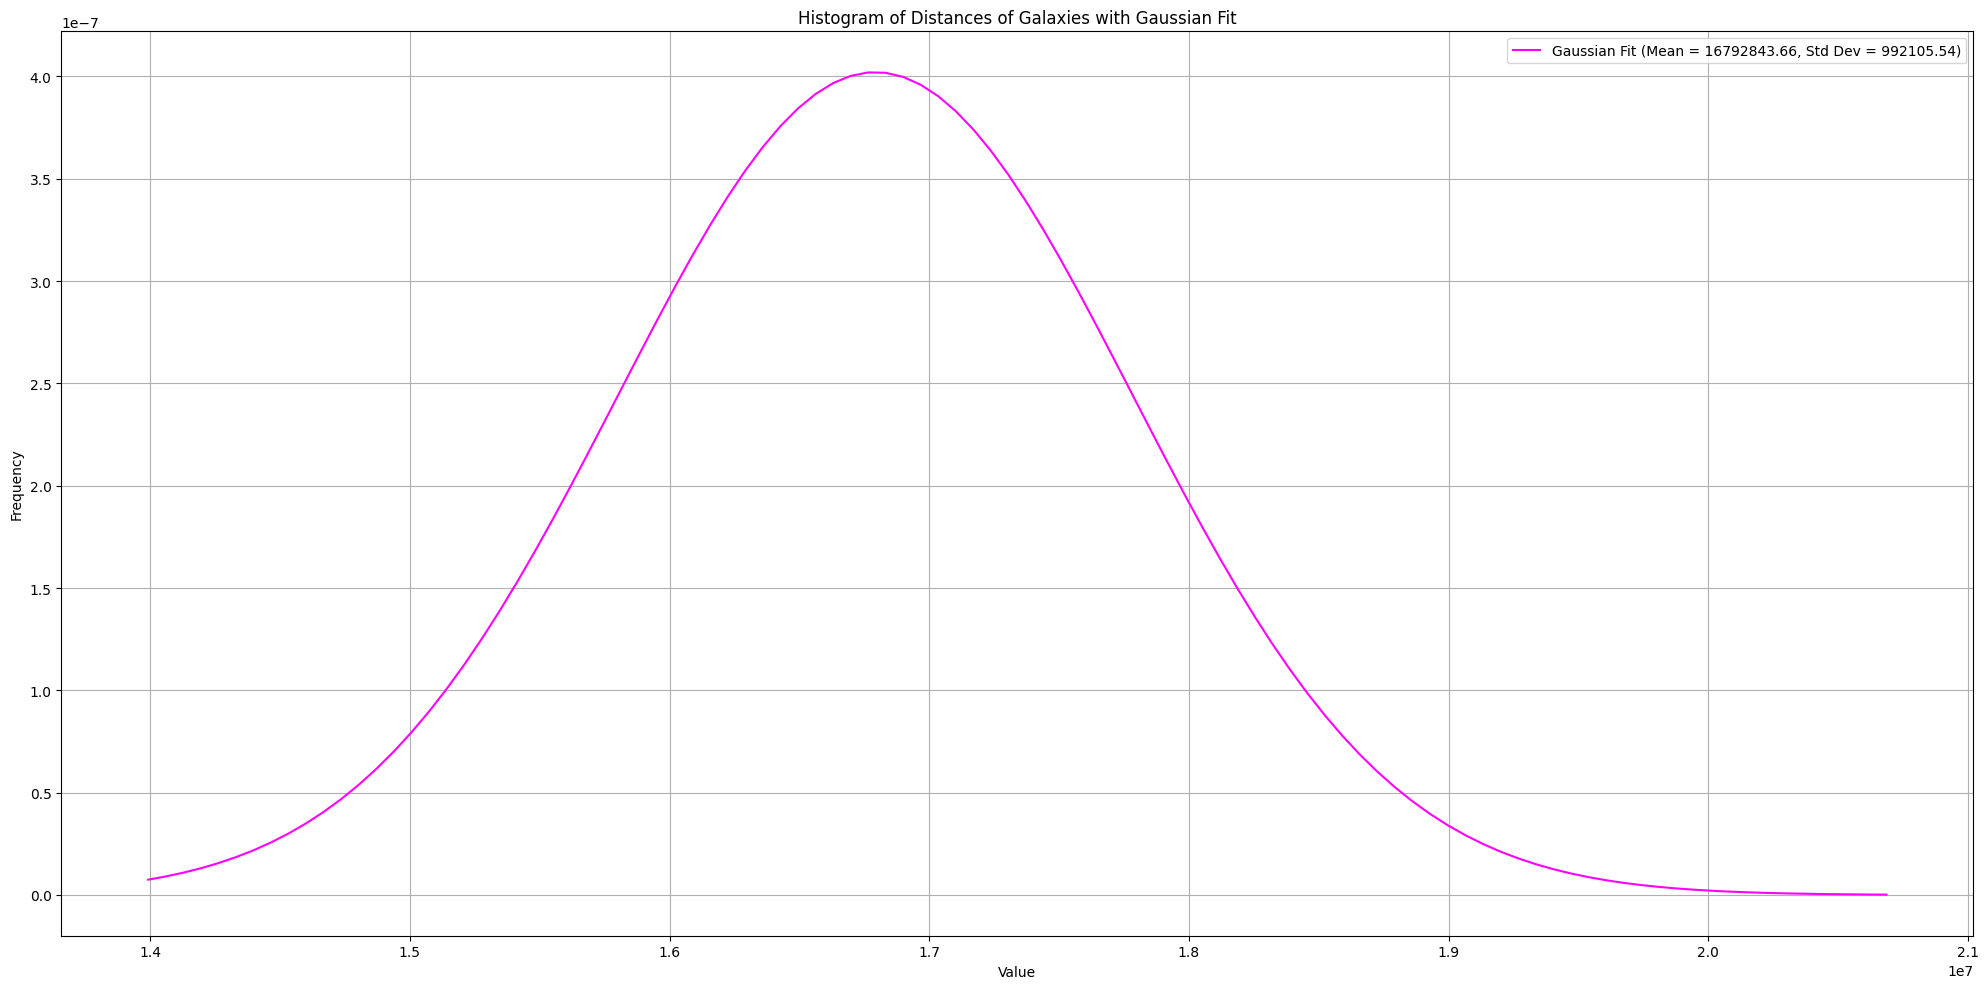

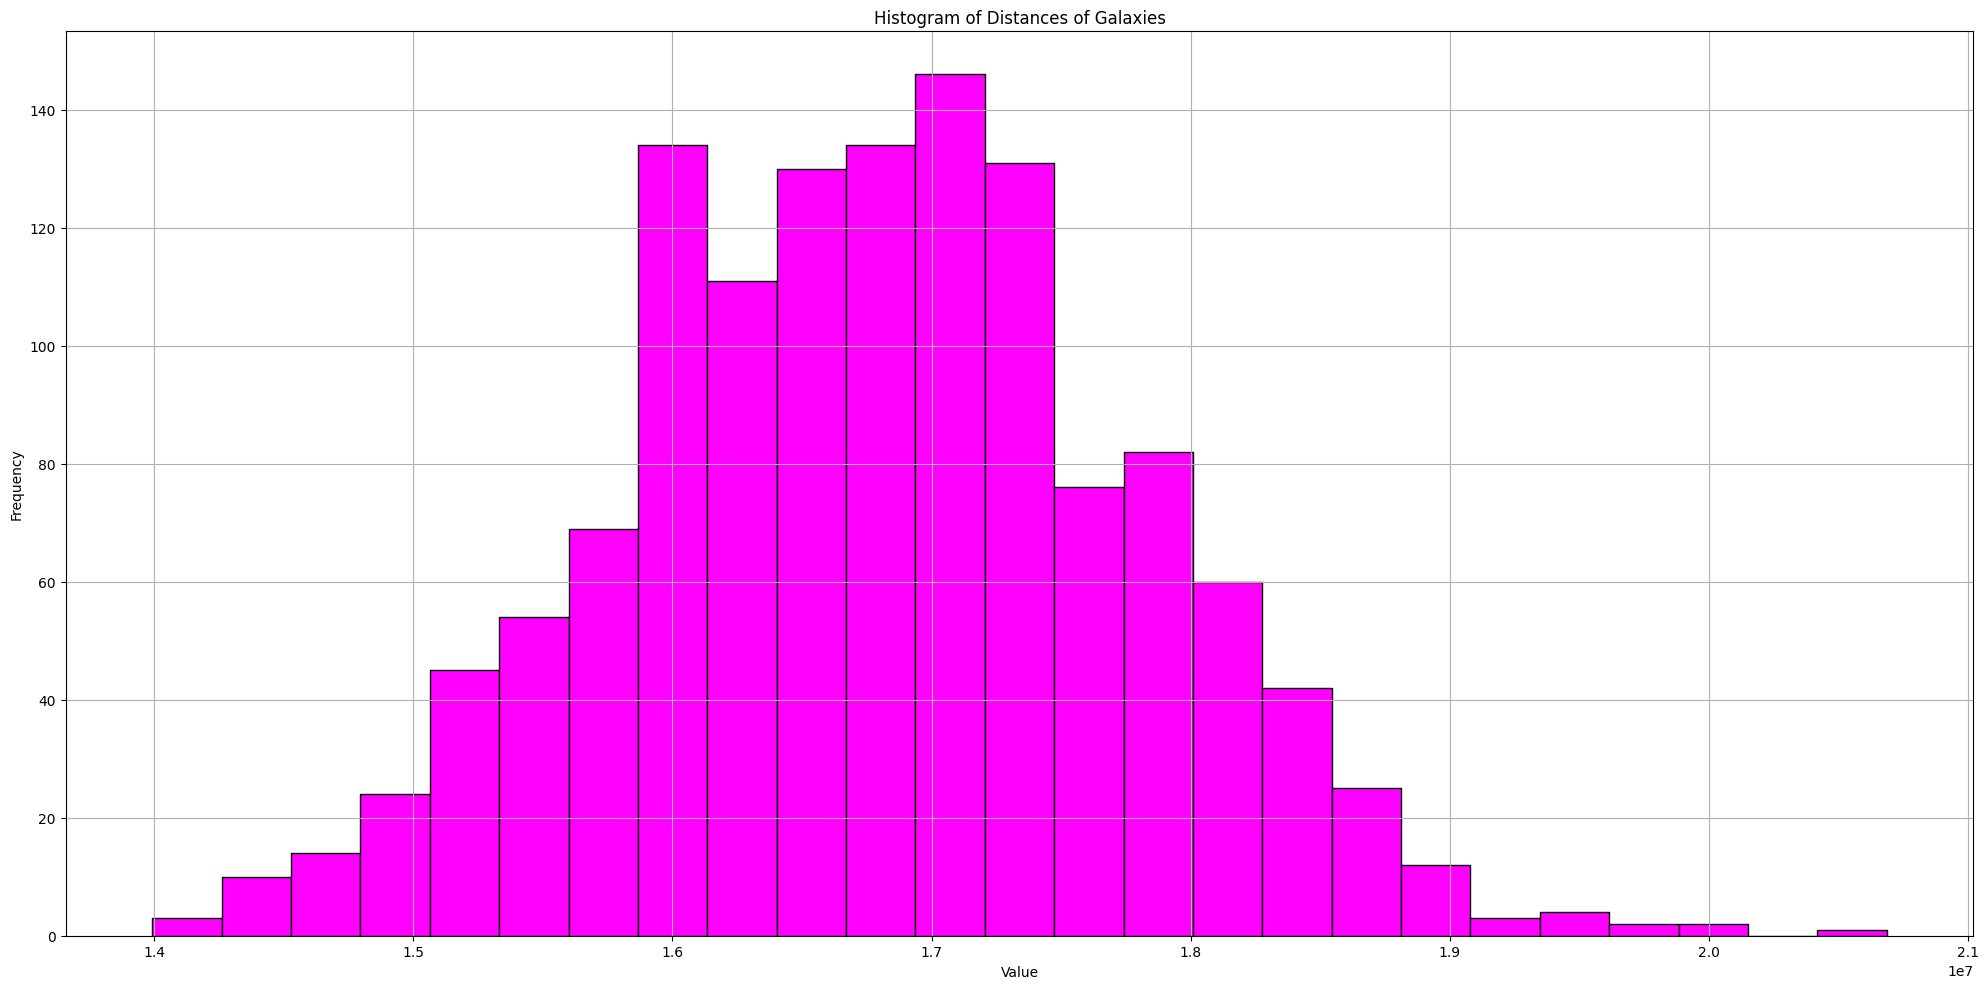

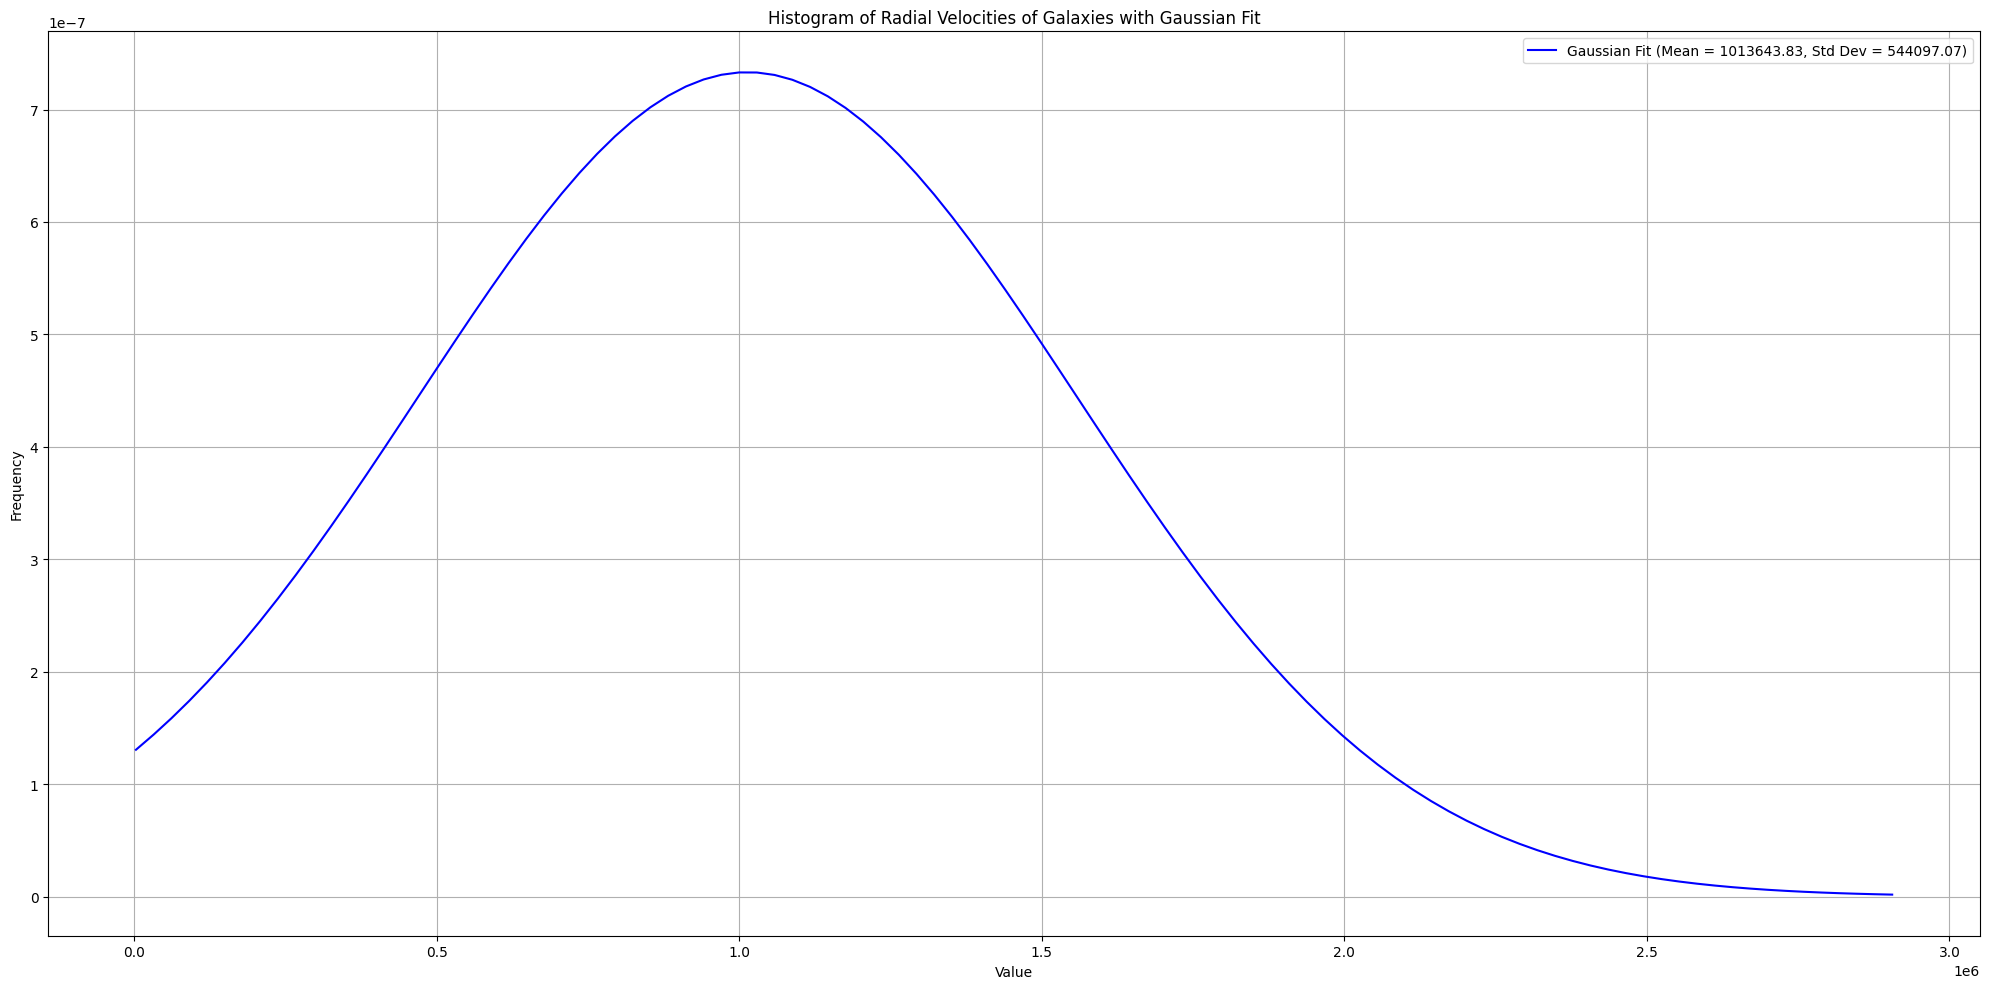

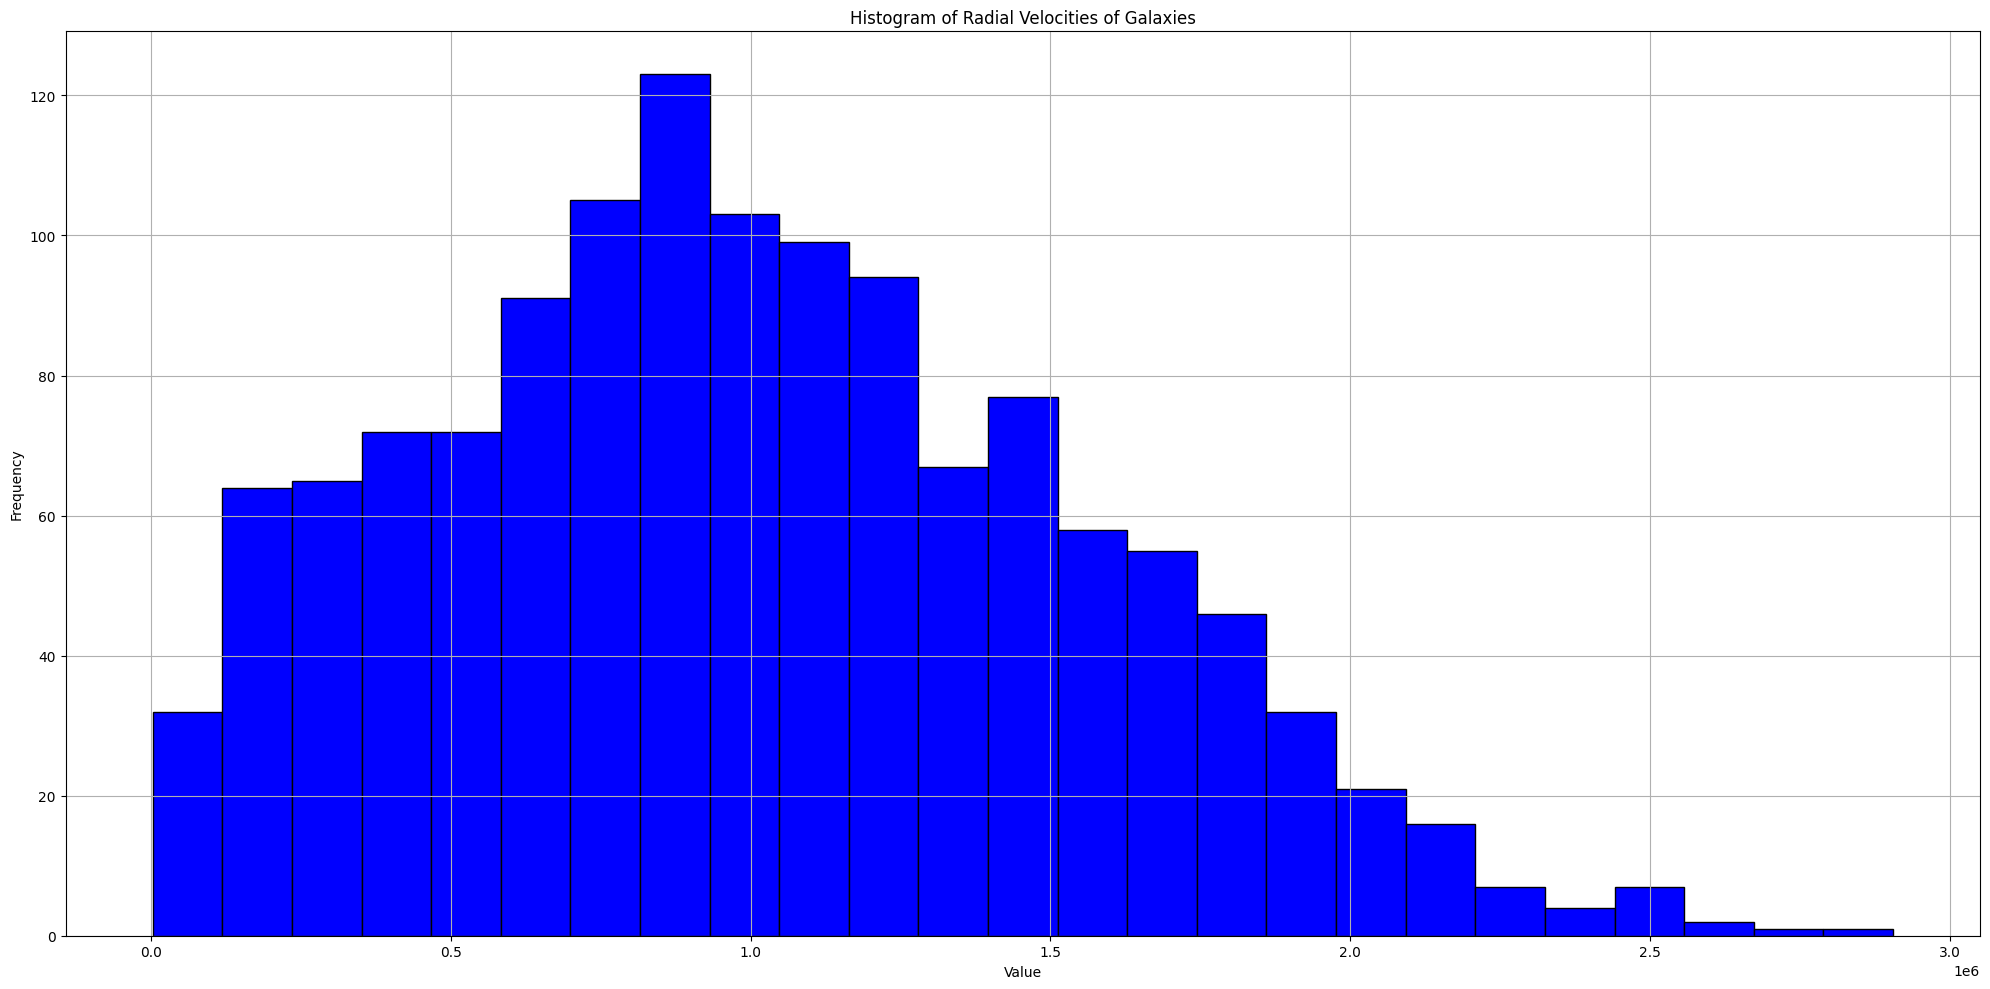

In [40]:
def fit_gaussian(data, title, color):
    mean = np.mean(data)
    std_dev = np.std(data)
    x = np.linspace(np.min(data), np.max(data), 100)
    y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    plt.figure(figsize=(20, 10))
    plt.plot(x, y, color=color, label=f'Gaussian Fit (Mean = {mean:.2f}, Std Dev = {std_dev:.2f})')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def histogram(data, title, color):
    plt.figure(figsize=(20, 10))
    plt.hist(data, bins=25, color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

galaxy_data = galaxy_data[(galaxy_data['Distance in parsecs'] > 0) & (galaxy_data['Radial Velocity'] > 0)]

fit_gaussian(galaxy_data['Distance in parsecs'], 'Histogram of Distances of Galaxies with Gaussian Fit', 'magenta')
histogram(galaxy_data['Distance in parsecs'], 'Histogram of Distances of Galaxies', 'magenta')
fit_gaussian(galaxy_data['Radial Velocity'], 'Histogram of Radial Velocities of Galaxies with Gaussian Fit', 'blue')
histogram(galaxy_data['Radial Velocity'], 'Histogram of Radial Velocities of Galaxies', 'blue')


Using the values obtained in the previous part, report your value of $H$ along with the error margins.

In [41]:
galaxy_data = galaxy_data[(galaxy_data['Distance in parsecs'] > 0) & (galaxy_data['Radial Velocity'] > 0)]

mean_velocity = np.mean(galaxy_data['Radial Velocity'])
mean_distance = np.mean(galaxy_data['Distance in parsecs'])

def hubble_function(distance, hubble_constant):
    return hubble_constant * distance

# Fit the Hubble function to the data to find Hubble's constant
initial_guess = 70.0  # Initial guess for Hubble's constant
popt, pcov = curve_fit(hubble_function, galaxy_data['Distance in parsecs']/1000000, galaxy_data['Radial Velocity']/1000, p0=initial_guess)

hubble_constant = popt[0]
hubble_constant_error = np.sqrt(np.diag(pcov))[0]
print(f"Hubble's Constant: {hubble_constant:.10f} ± {hubble_constant_error:.10f} km/s/Mpc")

# peak of the gaussian for distance
distance_peak = np.mean(galaxy_data['Distance in parsecs'])
# peak of the gaussian for velocity
velocity_peak = np.mean(galaxy_data['Radial Velocity'])

# Calculate hubble constant using the peak values
hubble_constant_peak = (velocity_peak * 1000000) / (distance_peak * 1000)
print(f"Hubble's Constant (Peak): {hubble_constant_peak:.10f} km/s/Mpc")

# I have mentioned 2 values for Hubble's constant because the value obtained from the peak values is different from the value obtained from the curve fit

Hubble's Constant: 60.2993082575 ± 0.8904130955 km/s/Mpc
Hubble's Constant (Peak): 60.3616548857 km/s/Mpc


***

#### Q4.1 Compare the value of $H$ that you got from the standard $H_0$ commonly accepted today. The estimate that you got - is it the same (within error margins), higher or lower than the value of $H_0$.

The value of Hubble's constant which I got is lower than then standard value commonly accepted today, and the standard value is not withing the error margins of the value which we have gotten.

***

#### Q4.2 What might be the reason behind this difference in values


The difference between computationally calculated and standardized values of Hubble's constant could be due to various factors like uncertainties in measuring distances to galaxies, the effects of dark matter and limitations in observational techniques or errors in data analysis.
***

# Section 5 : Dark Matter

Dark matter is a component of the universe whose presence is discerned from its gravitational attraction rather than its luminosity.

***

#### Q5.1 ESTIMATE the total mass of the Galaxy Cluster. This includes mass due to visible matter as well as dark matter.

HINT: The [Virial Theorem](https://phys.libretexts.org/Bookshelves/Classical_Mechanics/Variational_Principles_in_Classical_Mechanics_%28Cline%29/02%3A_Review_of_Newtonian_Mechanics/2.11%3A_Virial_Theorem) provides a general equation that relates the average over time of the total kinetic energy of a stable system of discrete particles, bound by a conservative force
 $$ \left<KE\right> = -\frac{1}{2} \left<PE\right> $$

In [42]:
# Using the hint, we get the approximate formula for total mass of the Galaxy Cluster as R*v^2/G where R is the distance to the cluster, v is the average radial velocity of the galaxies in the cluster and G is the gravitational constant
G = 6.67430e-11 # Gravitational constant in m^3/kg/s^2

mean_distance = galaxy_data['Distance in parsecs'].mean() * u.parsec.to('m')
mean_velocity = galaxy_data['Radial Velocity'].mean()
total_mass = mean_distance * mean_velocity ** 2 / G
print(f"Total Mass of the Galaxy Cluster: {total_mass:.6e} kg")


Total Mass of the Galaxy Cluster: 7.977004e+45 kg



***

#### Q5.2 ESTIMATE the visible mass in the galaxy cluster. Use the Mass - Luminosity Relation for Main-Sequence Stars, assuming that it holds well for galaxies too. You may use the Milky Way as a reference.

Absolute Magnitude of Milky Way $ \approx -21 mag$

Visible mass of Milky Way $\approx 2 \times 10 ^ {11} M_{sun}$

In [43]:
absolute_magnitude_milky_way = -21
visible_mass_milky_way = 2e11 * u.solMass.to('kg')
# Calculate the luminosity of the Milky Way
luminosity_milky_way = 10 ** ((4.77 - absolute_magnitude_milky_way) / 2.5)

# Calculate the absolute magnitude of the galaxies in the galaxy cluster
galaxy_data['Absolute Magnitude'] = - 5 * np.log10(galaxy_data['Distance in parsecs']) + 5 + galaxy_data['Apparent Mag']
# print(galaxy_data['Absolute Magnitude'], galaxy_data['Apparent Mag'])

# Calculate the visible mass of the galaxies in the galaxy cluster using the mass luminosity relation for main sequence stars
galaxy_data['Luminosity'] = luminosity_milky_way * 10 ** (0.4 * (absolute_magnitude_milky_way - galaxy_data['Absolute Magnitude']))
galaxy_data['Visible Mass'] = ((galaxy_data['Luminosity'] / luminosity_milky_way) ** (1/3.5)) * visible_mass_milky_way # a = 3.5 for main sequence stars

total_visible_mass = galaxy_data['Visible Mass'].sum()
print(f"Total Visible Mass of the Galaxy Cluster: {total_visible_mass:.6e} kg")

galaxy_data.to_csv('data/galaxy.csv', index=False)


Total Visible Mass of the Galaxy Cluster: 2.379071e+44 kg


***

#### Q5.3 What is the fraction of the total mass of the galaxy cluster that is actually in the form of Dark Matter

\< Your answer here \>



In [44]:
# fraction of the total mass of the galaxy cluster that is actually in the form of Dark Matter
fraction_dark_matter = 1 - total_visible_mass / total_mass
print(f"Fraction in the form of Dark Matter: {fraction_dark_matter:.10f}")

Fraction in the form of Dark Matter: 0.9701758903


***
